<h1>Oceanography: Predicting Salinity in Water</h1>

<p>This data contains oceanographic data from over 60 year ago up to now, collected and organized by CalCOFI. The data holds many different variables relating to depth, temprature, salinity, and water density. You can see the explanations for all columns <a href="https://new.data.calcofi.org/index.php/database/calcofi-database/bottle-field-descriptions">here.</a></p>

<h2>The Target</h2>
<p>In this notebook, we'll be trying to predict salinity mainly using depth, and later temprature and water density.</p>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer

In [3]:
bot = pd.read_csv('bottle.csv', low_memory=False)

<h1>Exploratory Data Analysis and Data Cleaning</h1>
<p>Let's start with some basic EDA, and also get ready for cleaning that we may need to do in order to properly use the data.</p> 

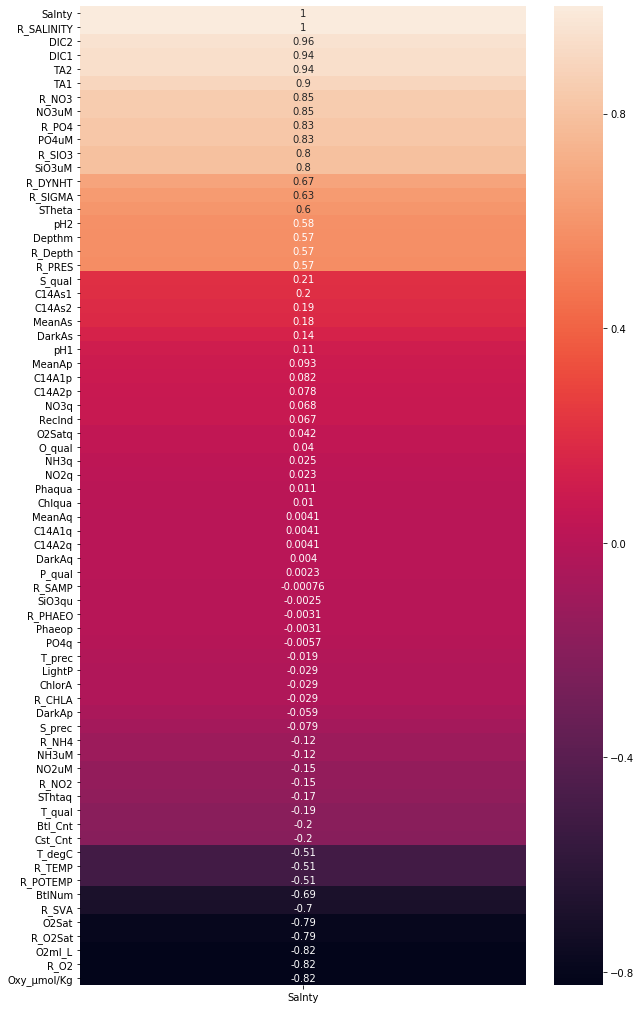

In [4]:
plt.figure(figsize = (10,18))

sns.heatmap(bot.select_dtypes(['int64', 'int', 'float']).corr()[['Salnty']].sort_values(by = 'Salnty', ascending = False), annot = True)

<h6>Here we have a heatmap for correlation to keep in mind as we form our models later. Although there are certain copies of columns like R_SALINITY which we can ignore.
<br>
    
    
We also have a quick description of all the columns and how many NaN values they contain. We will be prioritizing columns where we can delete the smallest number of data entries.</h6> 

In [5]:
bot.isnull().sum(axis = 0).sort_values()

Cst_Cnt                     0
Btl_Cnt                     0
Sta_ID                      0
Depth_ID                    0
Depthm                      0
R_PRES                      0
R_Depth                     0
RecInd                      0
T_degC                  10963
T_prec                  10963
R_TEMP                  10963
C14A2q                  16240
C14A1q                  16258
DarkAq                  24423
MeanAq                  24424
R_POTEMP                46047
R_DYNHT                 46657
R_SALINITY              47354
S_prec                  47354
Salnty                  47354
STheta                  52689
R_SVA                   52771
R_SIGMA                 52856
NH3q                    56564
R_O2                   168662
O2ml_L                 168662
P_qual                 191108
R_O2Sat                198415
O2Sat                  203589
Oxy_µmol/Kg            203595
                        ...  
R_CHLA                 639587
R_PHAEO                639588
ChlorA    

<h6>Now let's see what salinity looks like in reference to depth.</h6> 

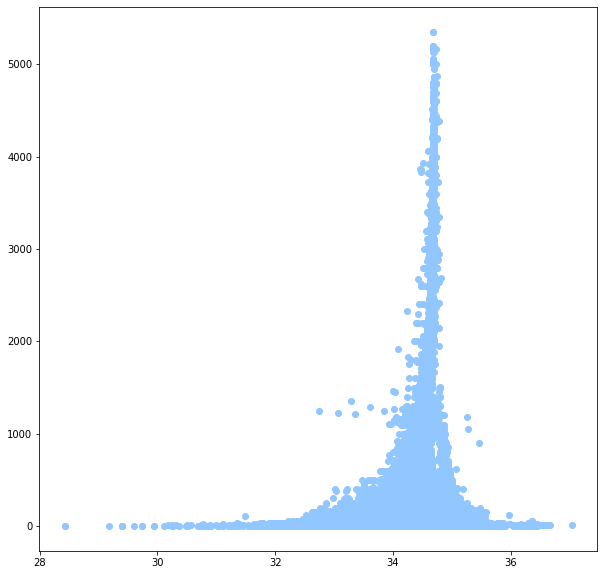

In [6]:
plt.figure(figsize = (10,10))

plt.scatter(bot['Salnty'], bot['Depthm'])

<h6>There is a correlation, but the curve on depth is extremely high. We can see we'll probably need some polynomial mathmatics to properly curve a line increase that sudden.</h6> 

<h1>Model I: Basic Depth and Linear Regression</h1>
<p>Let's start by dropping the NaN rows in the dataset and testing a basic linear regression model.</p> 

In [7]:
bot.dropna(subset=['Salnty', 'Depthm'], inplace=True)

In [8]:
X = bot[['Depthm']]
y = bot.Salnty

lr = LinearRegression()
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
preds = lr.predict(X)
    
mse = mean_squared_error(y, preds)
print(np.sqrt(mse))
    
lr.score(X, y)

0.3786252934366423


0.3279054672714089

<h6>Well that isn't a great score. I'm sure we can get better results by improving the model a bit.</h6> 

<h1>Model II: More Correlations and PolynomialFeatures</h1>
<p>This time around we'll add some new metrics to predict salinity. Based on columns that have the least NaN values and the greatest correlation factors, we'll go with temperature and anomalies in volume. The reason we're using reported anomalies in volume with a negative correlation instead of typical reported water density is because it had both a stronger correlation (further from zero) and had less NaN values to remove.</p> 

In [10]:
bot.dropna(subset=['Salnty', 'Depthm', 'T_degC', 'R_SVA'], inplace=True)

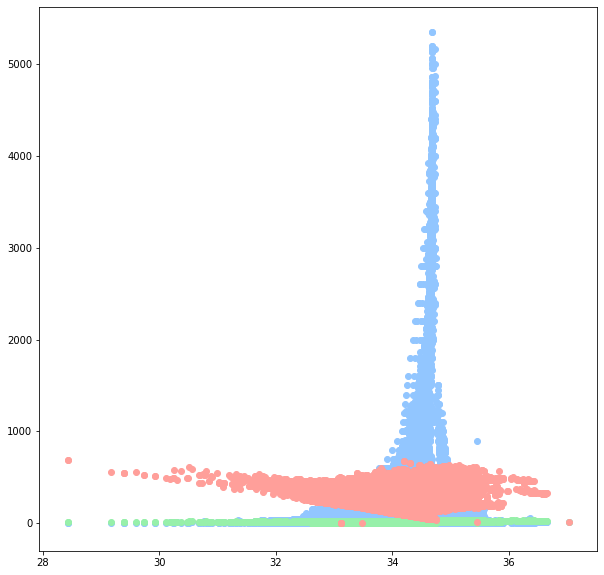

In [11]:
plt.figure(figsize = (10,10))

plt.scatter(bot['Salnty'], bot['Depthm'])

plt.scatter(bot['Salnty'], bot['T_degC'])

plt.scatter(bot['Salnty'], bot['R_SVA'])

In [12]:
X = bot[['Depthm', 'T_degC', 'R_SVA']]
y = bot.Salnty

lr = LinearRegression()
lr.fit(X,y)

preds = lr.predict(X)
    
mse = mean_squared_error(y, preds)
print(np.sqrt(mse))
    
lr.score(X, y)

0.10493470862527873


0.9482486720619221

<h6>Now that's a pretty significant improvement, but we can go further with some transformations. </h6>

In [13]:
pipe = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('lr', LinearRegression())])

pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
params = {'poly__degree': [1, 2, 3, 4, 5], 'lr__fit_intercept': [True, False]}

grid = GridSearchCV(pipe, param_grid = params, cv = 5)

In [15]:
grid.fit(X, y)
grid_preds = grid.predict(X)

In [16]:
mse = mean_squared_error(y, grid_preds)
print(np.sqrt(mse))

grid.score(X, y)

0.011928754429399798


0.99933123525182

<h6> And there we have it. With another plot we can see that for the most part, we have predicted salinity levels in the data quite well. <h6>

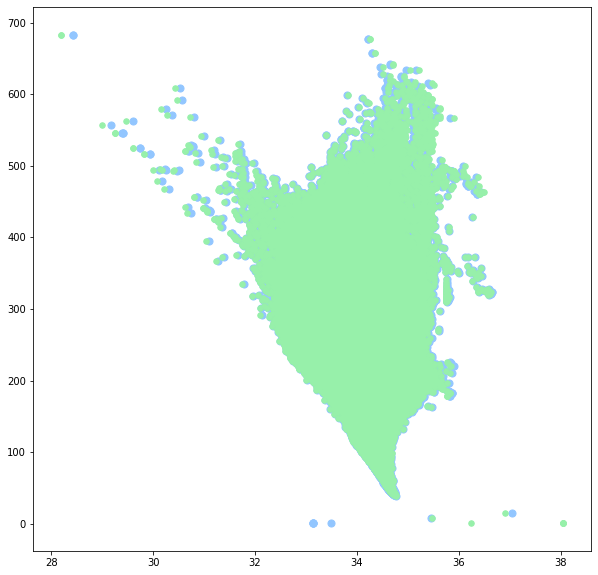

In [17]:
plt.figure(figsize = (10,10))

plt.scatter(bot['Salnty'], bot['R_SVA'], s = 50)

plt.scatter(grid_preds, bot['R_SVA'], s = 30)

<h2>Model III: Train Test Split </h2> 
<p>Now that we have an accurate model to work with, let's apply it to a train test split.</p> 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
pipe_split = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('lr', LinearRegression())])

split_pipe.fit(X_train, y_train)

NameError: name 'split_pipe' is not defined

In [ ]:
params = {'poly__degree': [1, 2, 3, 4, 5]}

grid_split = GridSearchCV(pipe_split, param_grid = params, cv = 5)

grid_split.fit(X_train, y_train)

In [ ]:
split_preds = grid.predict(X_test)

In [ ]:
mse_train = mean_squared_error(y_train, grid_split.predict(X_train))
mse_test = mean_squared_error(y_test, grid_split.predict(X_test))
print(f'Train RMSE:{np.sqrt(mse_train)}\nTest RMSE:{np.sqrt(mse_test)}')

split_pipe.score(X_test, y_test)

<h1>Final Thoughts</h1>
<p>From here, we can ask a couple different questions to possibly improve our regression further.</p>

<p>-Does the lack of heavy variance in salinity affect how easy it is to get significantly accurate results?
    
-Did the regression model overfit the data? If so, how can we dial back to help the predictions?
</p> 